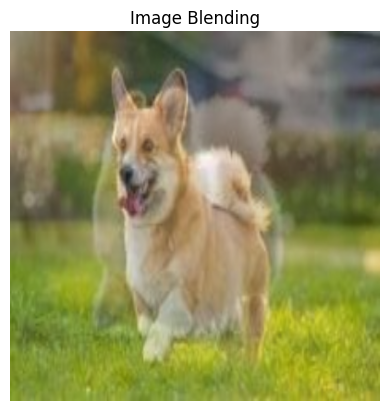

In [3]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread("image1.jpg")
img2 = cv2.imread("image2.jpg")
img1 = cv2.resize(img1, (400, 400))
img2 = cv2.resize(img2, (400, 400))

blended = cv2.addWeighted(img1, 0.6, img2, 0.4, 0)

plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Image Blending")
plt.axis('off')
plt.show()


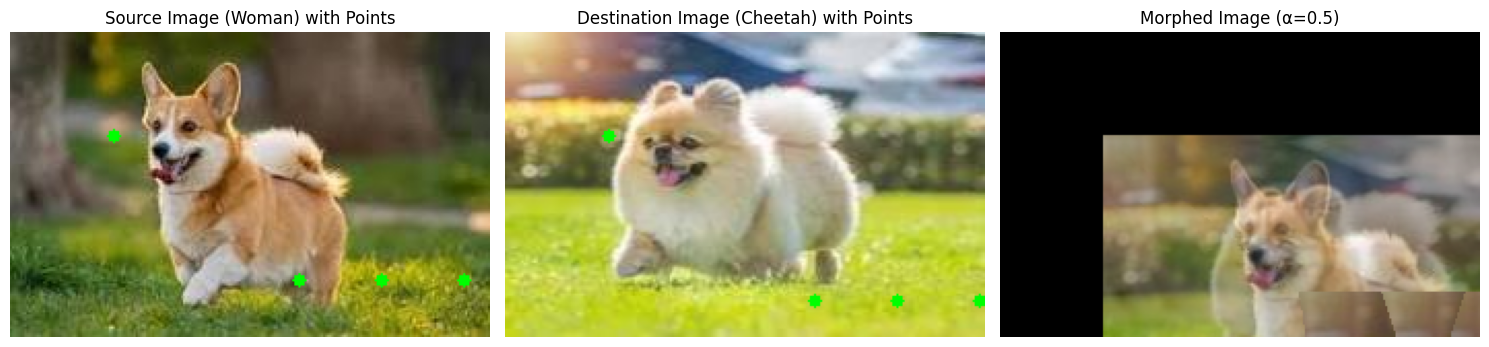

In [ ]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Function to apply affine transformation to a triangle
def apply_affine_transform(src, src_tri, dst_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[1], size[0]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

# Function to morph one triangle
def morph_triangle(img1, img2, img_m, t1, t2, t_m, alpha):
    r = cv2.boundingRect(np.float32([t_m]))
    img_h, img_w = img_m.shape[:2]
    x, y, w, h = r
    x = max(0, min(x, img_w - 1))
    y = max(0, min(y, img_h - 1))
    w = min(w, img_w - x)
    h = min(h, img_h - y)
    r = (x, y, w, h)
    if w <= 0 or h <= 0:
        return
    t1_rect = [(t1[i][0] - r[0], t1[i][1] - r[1]) for i in range(3)]
    t2_rect = [(t2[i][0] - r[0], t2[i][1] - r[1]) for i in range(3)]
    t_m_rect = [(t_m[i][0] - r[0], t_m[i][1] - r[1]) for i in range(3)]
    mask = np.zeros((r[3], r[2]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(t_m_rect), 255)
    img1_rect = apply_affine_transform(img1, t1, t_m, (r[3], r[2]))
    img2_rect = apply_affine_transform(img2, t2, t_m, (r[3], r[2]))
    img_m_rect = cv2.addWeighted(img1_rect, 1 - alpha, img2_rect, alpha, 0.0)
    mask_3d = mask[:, :, np.newaxis] / 255.0
    roi = img_m[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
    if roi.shape[:2] != mask.shape:
        print(f"Shape mismatch: ROI {roi.shape}, Mask {mask.shape}. Skipping triangle.")
        return
    img_m[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = roi * (1 - mask_3d) + img_m_rect * mask_3d

# Main morphing function
def morph_images(img1_path, img2_path, points1, points2, alpha=0.5):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    if img1 is None or img2 is None:
        raise ValueError("Could not load one or both images.")
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    points1 = np.array(points1, dtype=np.float32)
    points2 = np.array(points2, dtype=np.float32)
    points_m = (1 - alpha) * points1 + alpha * points2
    img_m = np.zeros_like(img1)
    tri = Delaunay(points_m)
    for simplex in tri.simplices:
        t1 = points1[simplex]
        t2 = points2[simplex]
        t_m = points_m[simplex]
        morph_triangle(img1, img2, img_m, t1, t2, t_m, alpha)
    return img1, img2, img_m

# Function to visualize feature points on images
def visualize_points(img, points, color=(0, 255, 0), radius=3):
    img_copy = img.copy()
    for p in points:
        cv2.circle(img_copy, (int(p[0]), int(p[1])), radius, color, -1)
    return img_copy

# Example usage
if __name__ == "__main__":
    # Paths to your images
    img1_path = r"image1.jpg"
    img2_path = r"image2.jpg"
    
    # Feature points for woman (img1) and cheetah (img2), assuming 500x500 images
    points1 = [
        [140, 120], [260, 120],  # Woman's left eye (outer, inner)
        [180, 120], [220, 120],  # Woman's left eye (center), right eye (center)
        [200, 180],              # Woman's nose tip
        [160, 250], [240, 250],  # Woman's mouth corners
        [50, 50], [450, 50],     # Top-left, top-right corners
        [50, 450], [450, 450],   # Bottom-left, bottom-right corners
        [250, 350]               # Chin
    ]
    points2 = [
        [150, 130], [270, 130],  # Cheetah's left eye (outer, inner)
        [190, 130], [230, 130],  # Cheetah's left eye (center), right eye (center)
        [210, 190],              # Cheetah's nose tip
        [170, 260], [250, 260],  # Cheetah's mouth corners
        [50, 50], [450, 50],     # Top-left, top-right corners
        [50, 450], [450, 450],   # Bottom-left, bottom-right corners
        [260, 360]               # Cheetah's chin
    ]
    
    # Morph with alpha = 0.5 for balanced blend
    alpha = 0.5
    try:
        # Get source, destination, and morphed images
        img1, img2, morphed_image = morph_images(img1_path, img2_path, points1, points2, alpha)
        
        # Visualize feature points
        img1_with_points = visualize_points(img1, points1)
        img2_with_points = visualize_points(img2, points2)
        
        # Convert BGR to RGB for Matplotlib display
        img1_rgb = cv2.cvtColor(img1_with_points, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(img2_with_points, cv2.COLOR_BGR2RGB)
        morphed_rgb = cv2.cvtColor(morphed_image, cv2.COLOR_BGR2RGB)
        
        # Display images side by side using Matplotlib
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img1_rgb)
        plt.title("Source Image (Woman) with Points")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(img2_rgb)
        plt.title("Destination Image (Cheetah) with Points")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(morphed_rgb)
        plt.title(f"Morphed Image (α={alpha})")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # Save the morphed image
        cv2.imwrite("morphed_image.jpg", morphed_image)
        
        # Optional: Display using OpenCV windows
        cv2.imshow("Source Image (Woman) with Points", img1_with_points)
        cv2.imshow("Destination Image (Cheetah) with Points", img2_with_points)
        cv2.imshow("Morphed Image", morphed_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    except Exception as e:
        print(f"Error: {e}")

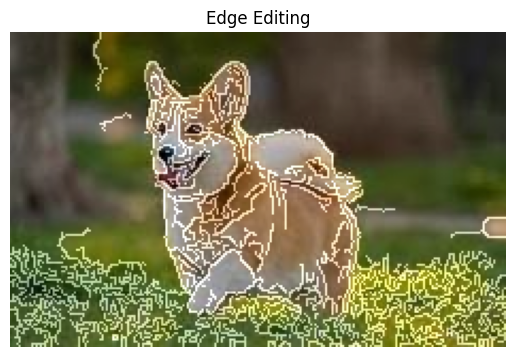

In [4]:
img = cv2.imread("image1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)
edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
edited = cv2.addWeighted(img, 0.8, edges_bgr, 0.5, 0)

plt.imshow(cv2.cvtColor(edited, cv2.COLOR_BGR2RGB))
plt.title("Edge Editing")
plt.axis("off")
plt.show()


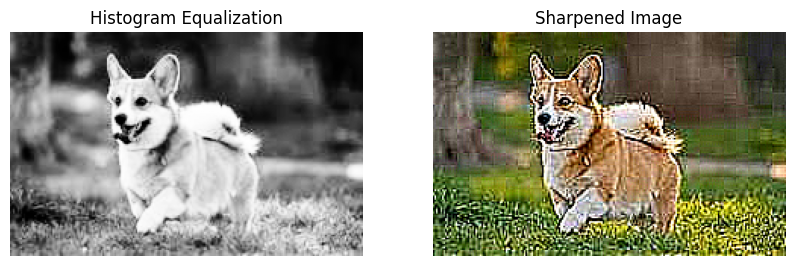

In [5]:
import numpy as np
img = cv2.imread("image1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)

kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(img, -1, kernel)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(equalized, cmap='gray')
plt.title("Histogram Equalization")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
plt.title("Sharpened Image")
plt.axis('off')
plt.show()
